In [1]:
import torch
import pandas as pd
import numpy as np
from numpy import random
import torch.nn as nn
from modules import EDMPrecond
from diffusion import *
from utils import *
from evaluate import *
from torch.amp import autocast
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from tabulate import tabulate


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/kapitann/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/kapitann/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/kapitann/.local/lib/python3.10/si

# Make predictions on test data

In [2]:
path = "models/edm_mse_loss_e300_bs16_do10_no-cg/ema_ckpt.pt"
print("Loading: ", path)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = EDMPrecond(img_resolution   = 1024,
                    img_channels    = 1,
                    label_dim       = 3,
                    use_fp16        = False,
                    sigma_min       = 0,
                    sigma_max       = float('inf'),
                    sigma_data      = 0.5,
                    model_type      = 'UNet_conditional',
                   device=device
                    ).to(device)
ckpt = torch.load(path,
                  map_location=device,
                  weights_only=True
                  )
model.load_state_dict(ckpt)

sampler = EdmSampler(net=model, num_steps=100)

Loading:  models/edm_mse_loss_e300_bs16_do10_no-cg/ema_ckpt.pt
Using device: cuda:1


In [3]:
x_real, cond_vectors, predictions = evaluate(model,
                      sampler,
                      device,
                      "../data/test_data_1024_[-1,1].csv",
                                            s_type='edm'
                                            )
x_real = np.array(x_real)
cond_vectors = np.array(cond_vectors)
predictions = np.array(predictions)

Testing loop: 100%|█████████████████████████████████████| 1567/1567 [1:26:17<00:00,  3.30s/it]


In [4]:
mse = np.mean((x_real - predictions) ** 2)
print(f"Mean test mse error: {mse}")

Mean test mse error: 0.0057259250815649265


In [ ]:
x_real

In [ ]:
predictions

In [ ]:
predictions[:, 0, 0, :]

In [ ]:
cond_vectors

# Save predictions

In [5]:
x_real_str = [','.join(map(str, row)) for row in x_real]
cond_vectors_str = [','.join(map(str, row)) for row in cond_vectors]
preds_str = [','.join(map(str, row)) for row in predictions[:, 0, 0, :]]

df = pd.DataFrame({'x_real': x_real_str, 'cond_vectors': cond_vectors_str, 'predictions': preds_str})
df.to_csv('results/predictions/preds_edm_mse_loss_e300_bs16_do10_no-cg.csv', index=False)

In [6]:
df.head()

,x_real,cond_vectors,predictions
0,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.3163244128227234,0.3391146957874298,0.0","-0.9816408157348633,-0.9725576639175415,-0.977..."
1,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.27736008167266846,0.44142237305641174,0.0","-1.0,-0.9941055178642273,-0.9857335090637207,-..."
2,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.6772092580795288,0.2812798023223877,0.0","-0.9999349117279053,-0.9968849420547485,-0.984..."
3,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.5888327956199646,0.7273106575012207,0.0","-0.9775495529174805,-0.9687126874923706,-0.965..."
4,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.3009049892425537,0.22526775300502777,0.0","-0.997623860836029,-0.9897497296333313,-0.9788..."


In [7]:
# Load data
df = pd.read_csv('results/predictions/preds_edm_mse_loss_e300_bs16_do10_no-cg.csv')

# Function to convert comma-separated strings to lists of floats
def str_to_float_list(s):
    return np.array(list(map(float, s.split(','))))

x_real = np.array([str_to_float_list(row) for row in df['x_real']])
cond_vectors = np.array([str_to_float_list(row) for row in df['cond_vectors']])
predictions = np.array([str_to_float_list(row) for row in df['predictions']])

df.head()

,x_real,cond_vectors,predictions
0,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.3163244128227234,0.3391146957874298,0.0","-0.9816408157348633,-0.9725576639175415,-0.977..."
1,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.27736008167266846,0.44142237305641174,0.0","-1.0,-0.9941055178642273,-0.9857335090637207,-..."
2,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.6772092580795288,0.2812798023223877,0.0","-0.9999349117279053,-0.9968849420547485,-0.984..."
3,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.5888327956199646,0.7273106575012207,0.0","-0.9775495529174805,-0.9687126874923706,-0.965..."
4,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.3009049892425537,0.22526775300502777,0.0","-0.997623860836029,-0.9897497296333313,-0.9788..."


# Intro into data

In [8]:
# Find indices and values greater than 0.5
indices = np.where(np.any(x_real > 0.5, axis=1))[0]
filtered_values = [x_real[idx][x_real[idx] > 0.5] for idx in indices]
filtered_predictions = [predictions[idx][x_real[idx] > 0.5] for idx in indices]

# Flatten results and take the first 50
flat_filtered_values = np.concatenate(filtered_values)[:50]
flat_filtered_predictions = np.concatenate(filtered_predictions)[:50]

# Print the results side by side
print("Filtered Values (greater than 0.5) from x_real and corresponding Predictions:")
for value, prediction in zip(flat_filtered_values, flat_filtered_predictions):
    print(f"{value:.5f}\t\t\t{prediction:.5f}")

Filtered Values (greater than 0.5) from x_real and corresponding Predictions:
0.51407			0.46918
0.65096			0.61517
0.78482			0.73110
0.89267			0.85555
0.97221			0.93868
1.00000			0.99521
1.00000			1.00000
1.00000			0.99173
0.96727			0.95318
0.82849			0.82770
0.73080			0.71725
0.61790			0.63204
0.52190			0.48815
0.55391			0.63522
0.67699			0.75744
0.78227			0.87086
0.87054			0.95989
0.94814			0.99917
0.91525			0.99783
0.96301			1.00000
0.90360			0.93389
0.78227			0.81226
0.70256			0.69803
0.59787			0.59128
0.50855			0.48714
0.54796			0.54701
0.68742			0.70283
0.81460			0.81748
0.90345			0.91914
0.95629			0.97812
1.00000			1.00000
0.93835			0.97769
0.95377			0.97184
0.87022			0.88494
0.72938			0.74287
0.62246			0.61973
0.50288			0.51110
0.54077			0.58927
0.68126			0.73012
0.81203			0.85160
0.91680			0.92665
0.97169			0.97888
1.00000			1.00000
0.97584			0.99681
1.00000			0.99343
0.92773			0.92327
0.78535			0.81042
0.68151			0.69677
0.56501			0.57330
0.60578			0.65544


In [9]:
# Find indices where predictions > 0.8 and corresponding x_real < 0.5
indices = np.where((predictions > 0.8) & (x_real < 0.1))

# Extract filtered values from x_real and predictions
filtered_x_real = x_real[indices]
filtered_predictions = predictions[indices]

# Print the results side by side
print("Filtered x_real (values < 0.1) and corresponding Predictions (values > 0.8):")
for x_val, pred_val in zip(filtered_x_real.flatten(), filtered_predictions.flatten()):
    print(f"{x_val:.5f}\t\t\t{pred_val:.5f}")

Filtered x_real (values < 0.1) and corresponding Predictions (values > 0.8):


# Visualization of results

In [10]:
wavelengths = np.load('../data/wavelengths.npy')

In [11]:
wavelengths

array([ 634.835144,  635.296997,  635.758911, ..., 1123.063232,
       1123.557739, 1124.052368])

## Plot predictions

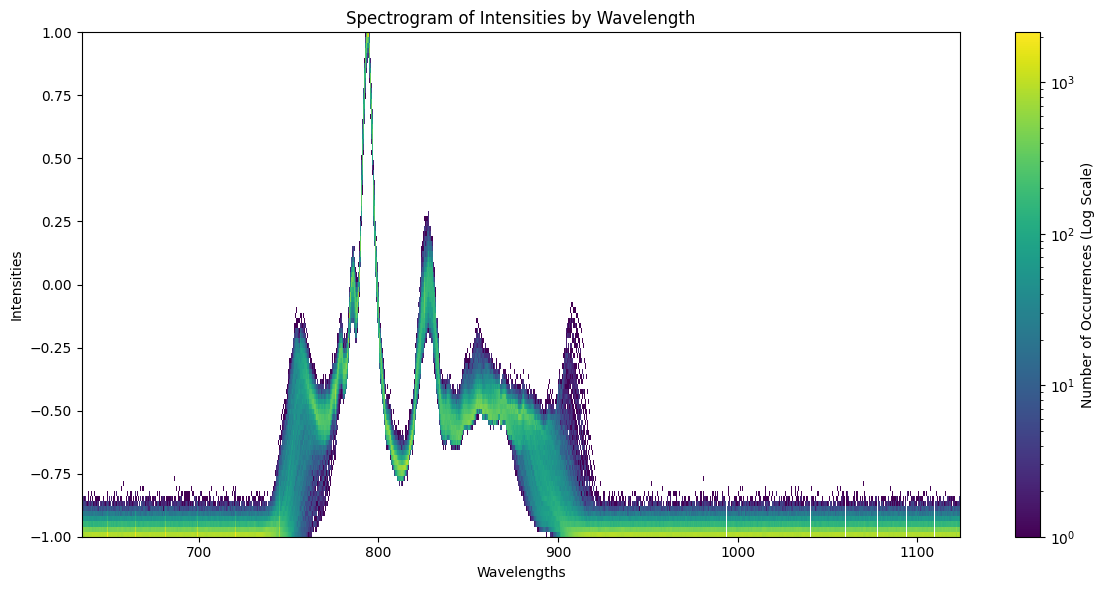

In [12]:
create_spectrogram(wavelengths, predictions, label="Spectrogram of Intensities by Wavelength")

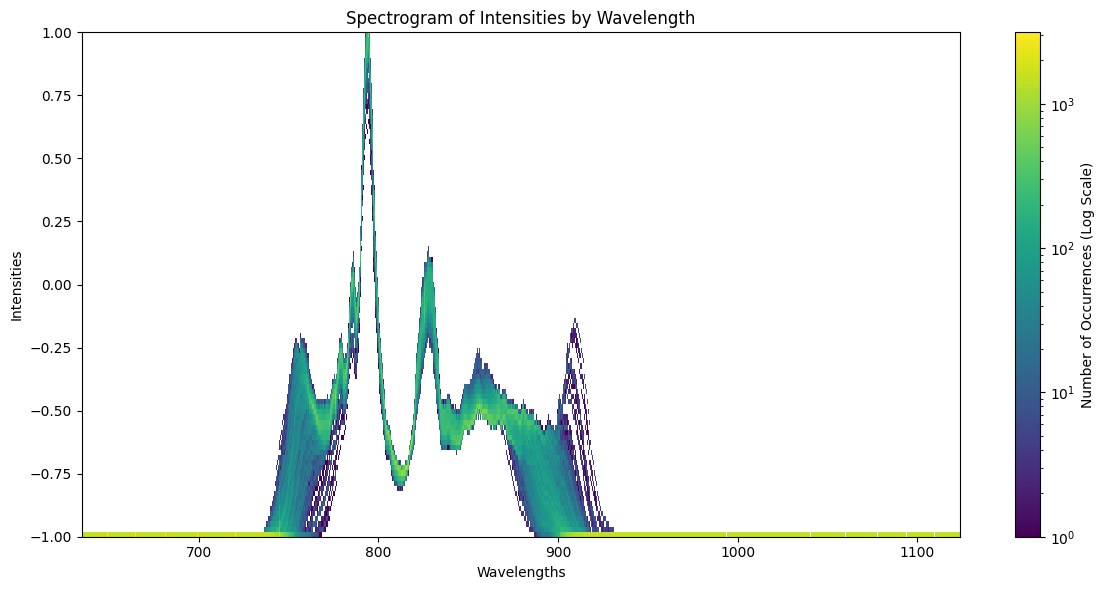

In [13]:
create_spectrogram(wavelengths, x_real, label="Spectrogram of Intensities by Wavelength")

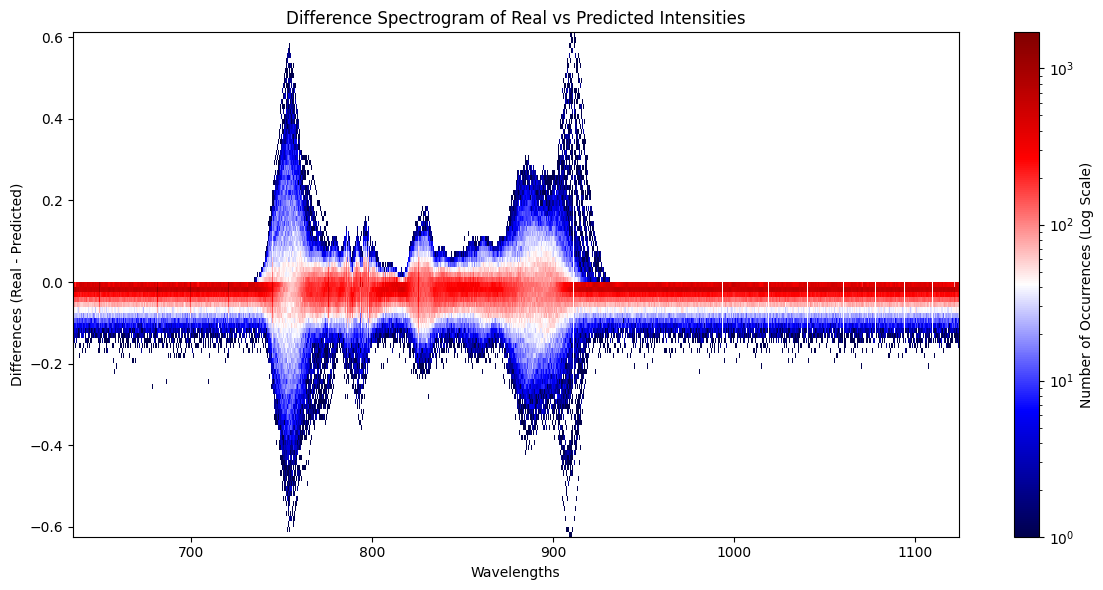

In [14]:
create_difference_spectrogram(wavelengths, 
                              x_real, 
                              predictions, 
                              label="Difference Spectrogram of Real vs Predicted Intensities")

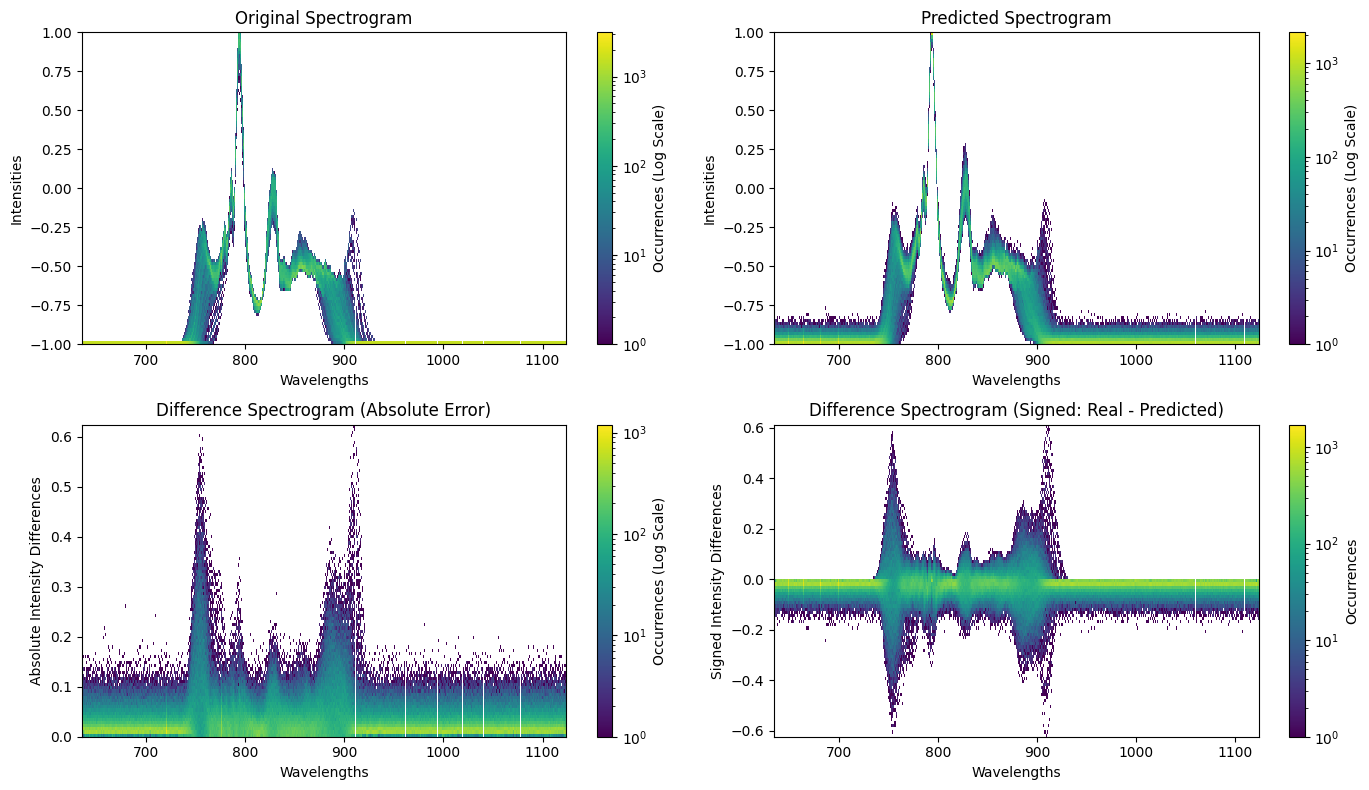

In [15]:
create_combined_spectrogram(wavelengths, 
                            x_real, 
                            predictions)

## Influence of parameters to predictions

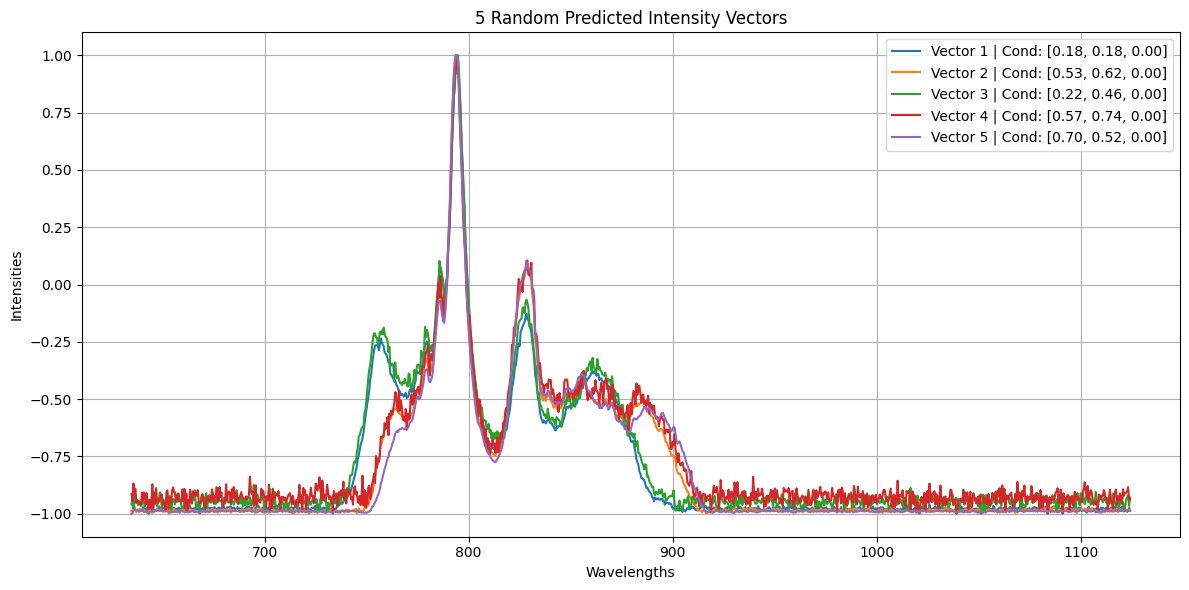

In [16]:
plot_random_intensity_vectors(wavelengths, predictions, cond_vectors)

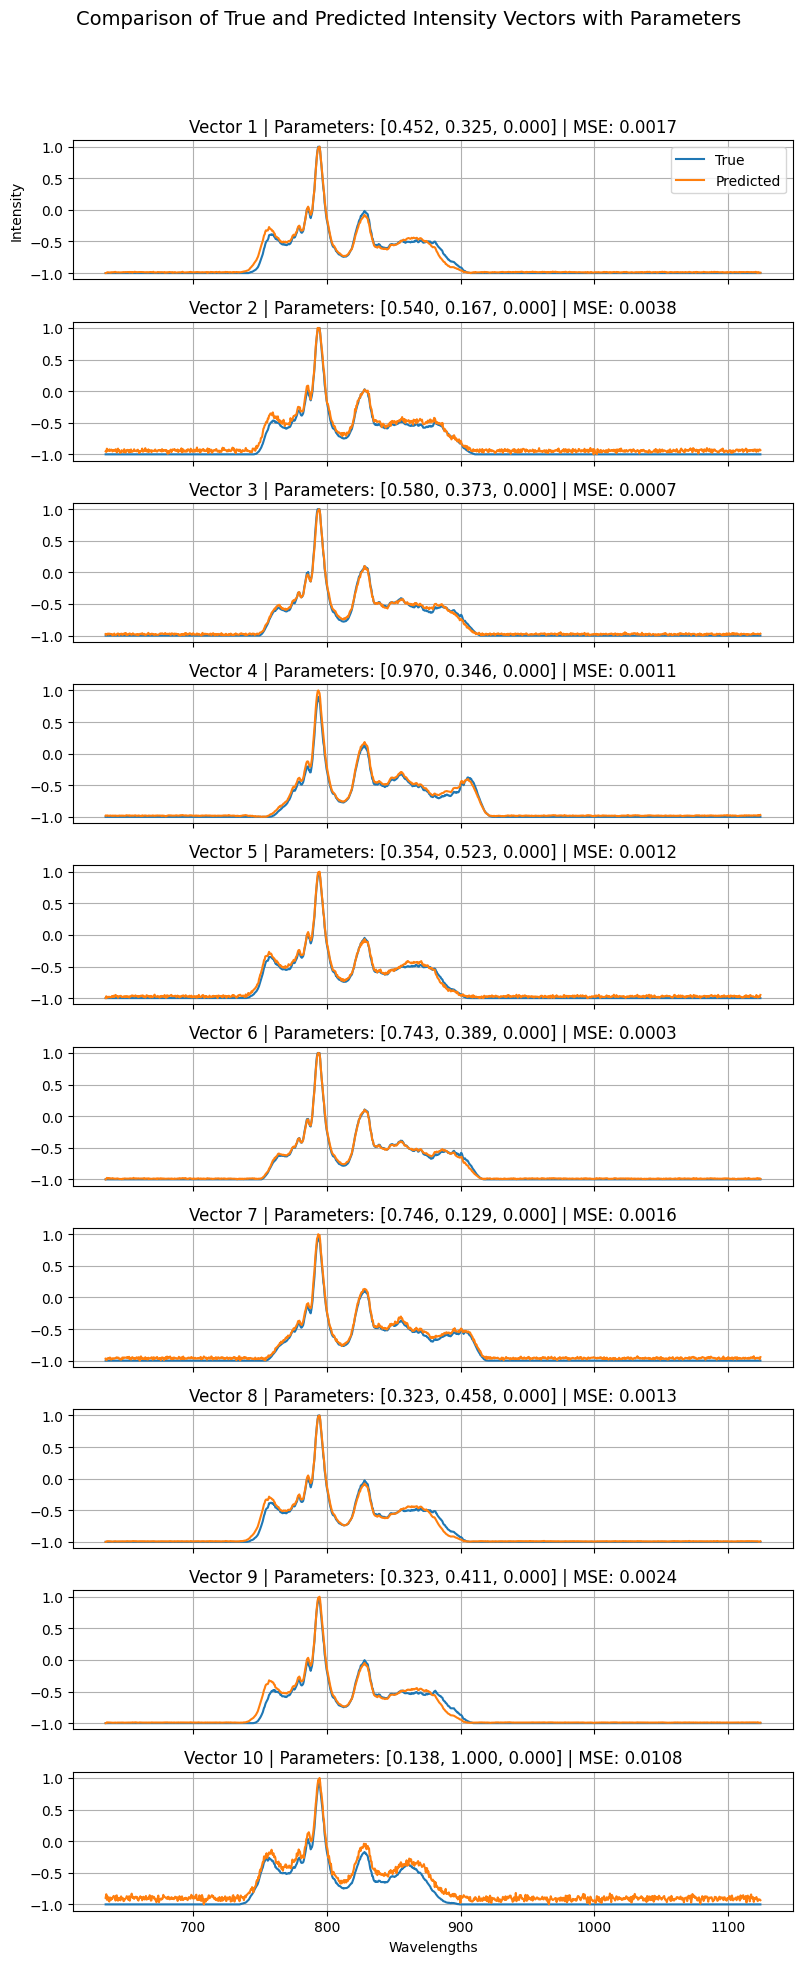

In [17]:
indices = np.random.choice(len(x_real), size=10, replace=False)

selected_real, selected_predicted, selected_conditions = plot_combined_intensity_vectors_with_parameters(
    wavelengths, x_real, predictions, cond_vectors, indices, num_vectors=10
)

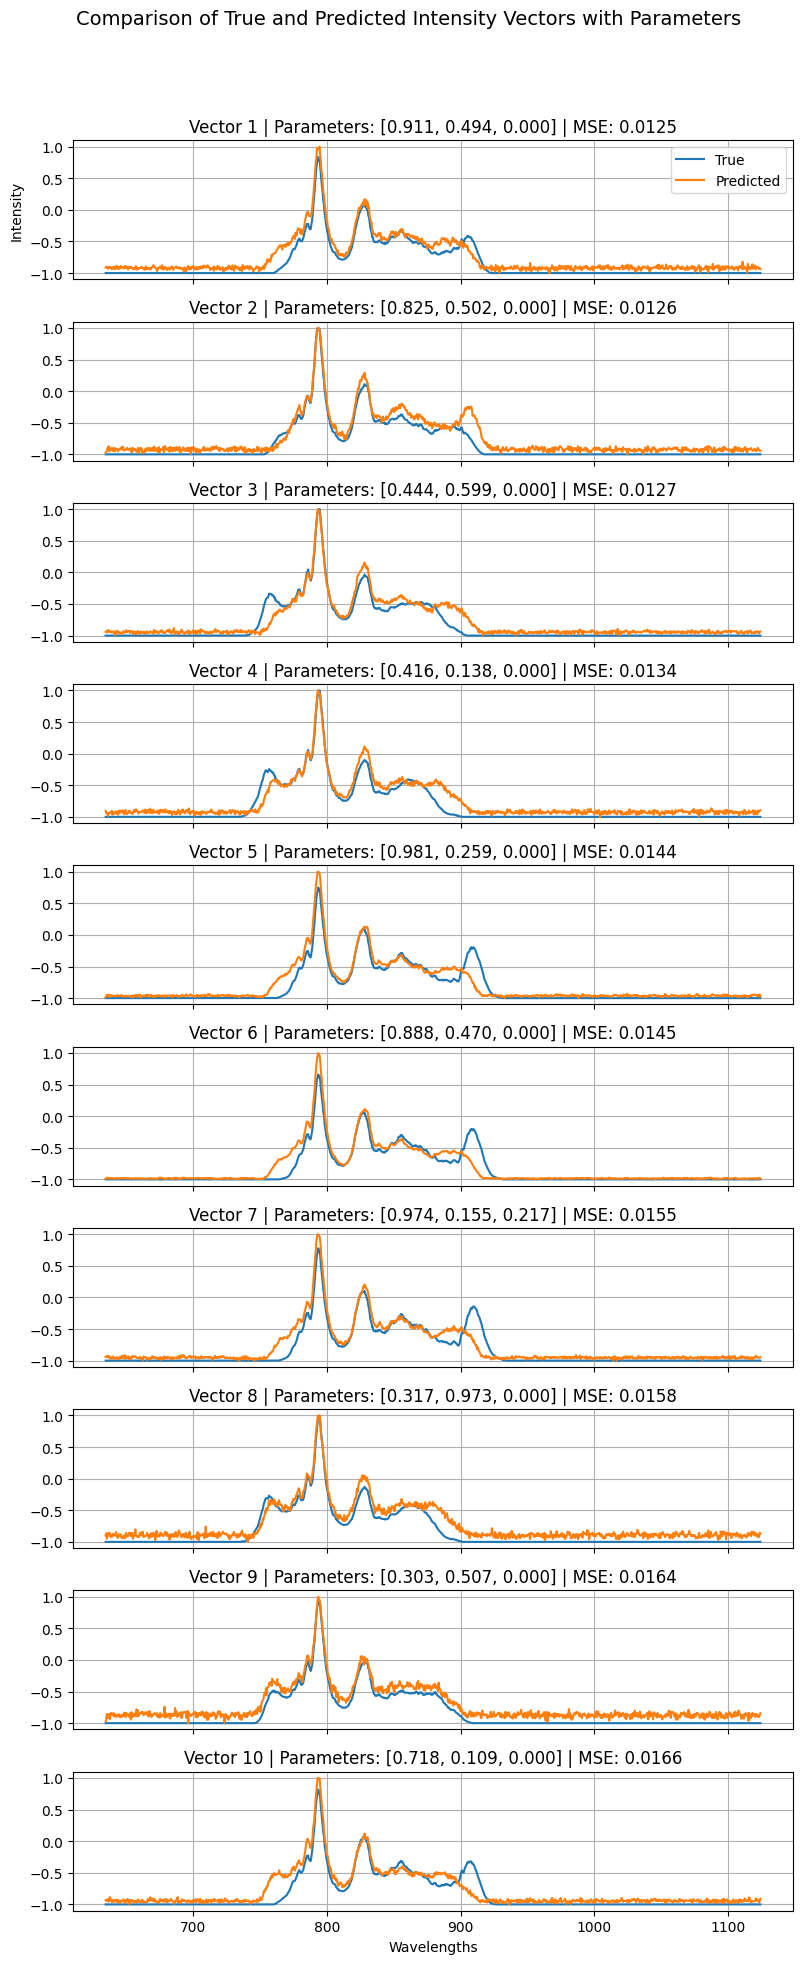

In [18]:
worst_indices = get_worst_mse_indices(x_real, predictions, n=10)
selected_real, selected_predicted, selected_conditions = plot_combined_intensity_vectors_with_parameters(
    wavelengths, x_real, predictions, cond_vectors, worst_indices, num_vectors=10
)

MSE Statistics:
Mean: 0.0024
Median: 0.0016
Standard Deviation: 0.0024
Min: 0.0001
Max: 0.0166
Range: 0.0166
Median (Q2): 0.0016
First Quartile (Q1): 0.0007
Third Quartile (Q3): 0.0033
Interquartile Range (IQR): 0.0026
Upper Whisker: 0.0073
Number of Outliers: 76.0000
Outliers: [0.008220592795277318, 0.008024920353021254, 0.00732678158925046, 0.00852910990646806, 0.0089366293259852, 0.008005610950343044, 0.014496208482682354, 0.008608321425912889, 0.009079004801409763, 0.010460918782270111]...


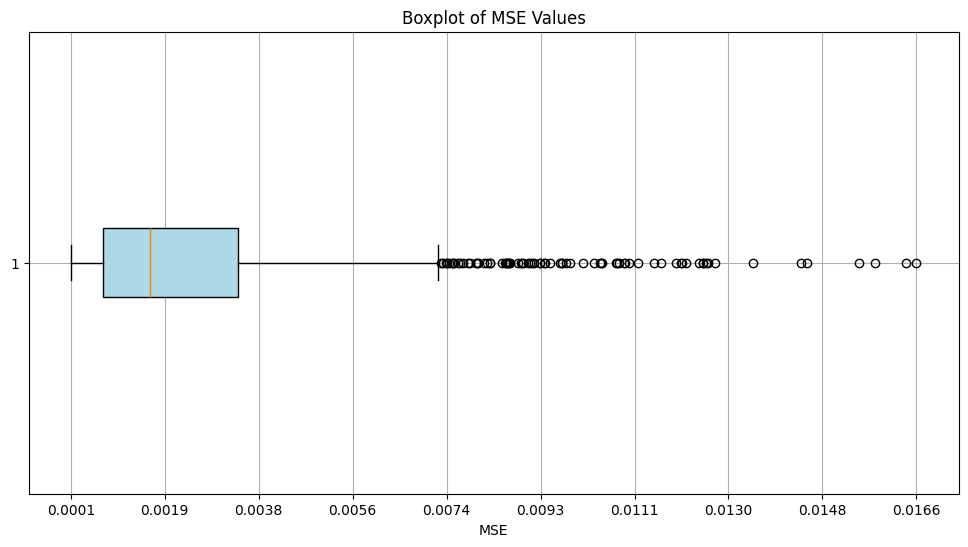

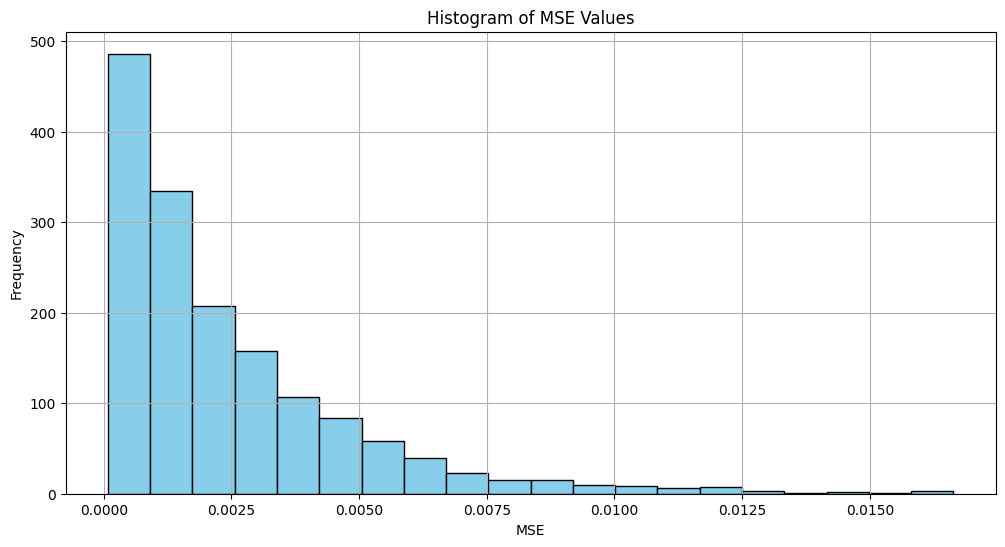

In [19]:
mse_stats = mse_statistics(x_real, predictions)


Number of vectors with high MSE (above upper whisker): 76
Number of vectors with low MSE (below or equal to upper whisker): 1491

Statistics for high MSE conditional vectors:
  Mean: [0.53303485 0.41367642 0.02563048]
  Median: [0.46808213 0.42749763 0.        ]
  Std: [0.21081071 0.23828595 0.09269028]
  Min: [0.13795491 0.02047781 0.        ]
  Max: [0.98060101 1.         0.4330357 ]

Statistics for low MSE conditional vectors:
  Mean: [0.43685442 0.45916672 0.00539846]
  Median: [0.41639015 0.47189546 0.        ]
  Std: [0.16459645 0.2114628  0.04586029]
  Min: [0.         0.00644275 0.        ]
  Max: [1.         1.         0.64880955]


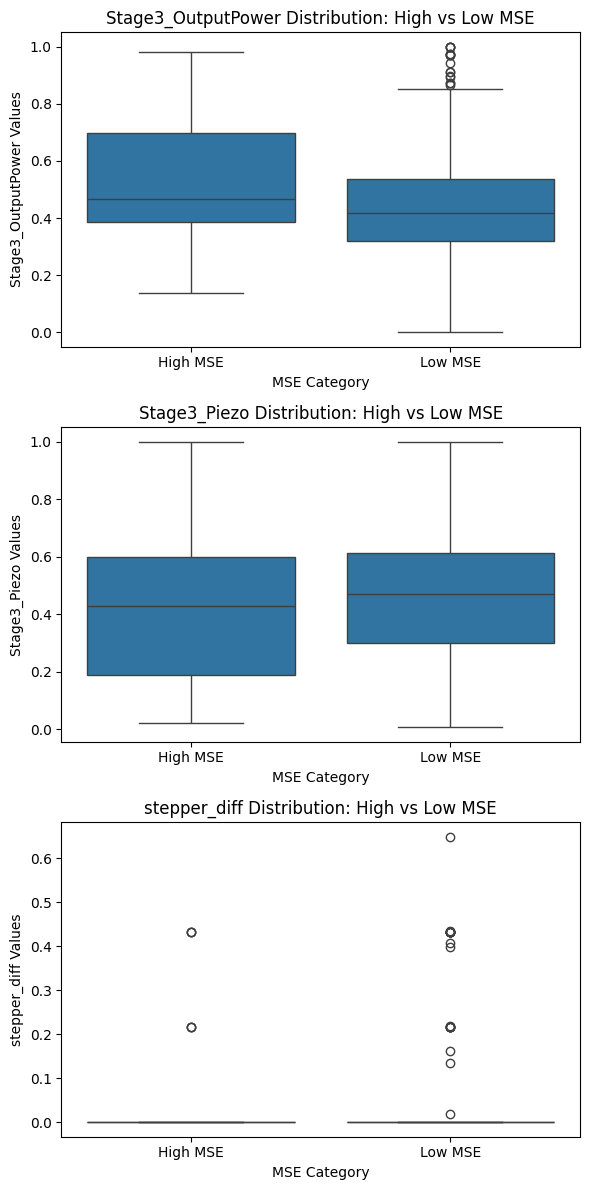

In [20]:
mse = np.mean((x_real - predictions) ** 2, axis=1)
parameter_names = ['Stage3_OutputPower', 'Stage3_Piezo', 'stepper_diff']
analyze_mse_and_cond_vectors(mse, cond_vectors, parameter_names)

## Try Random conditional vectors

In [23]:
df = pd.read_csv("../data/test_data_1024_[-1,1].csv")
df_subset = df.head(20)
new_cond_vectors = np.array([
    [ 214935.09855301,  269804.25447773, -418456.16068934],
    [ -93975.81857062,  120292.39937219,   82977.52669794],
    [ -93975.81857062,  -120292.39937219,   82977.52669794],
    [0,   0,   0],
    [  1,   1,  1],
    
    [ 1,    0,   0],
    [ 0,    1,   0],
    [ 0,    0,   1],
    [1,   1,   0],
    [  0,   1,  1],
    
    [ 1,    0,   1],
    [ 0.1,    0.1,   0],
    [ 0.3,    0.3,   0],
    [ 0.5,    0.5,   0],
    [ 0.7,    0.7,   0],
    
    [ 0.9,    0.9,   0],
    [ 0.1,    0.9,   0],
    [ 0.9,    0.1,   0],
    [ 0.5,    0.3,   0],
    [ 0.3,    0.5,   0],

])

df_subset['cond_vector'] = new_cond_vectors.tolist()
df_subset.to_csv("../data/data_nonsense.csv", index=False)

/tmp/ipykernel_1292584/1094714582.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['cond_vector'] = new_cond_vectors.tolist()


In [24]:
df_subset

,time,idx,cond_vector,intensities
0,2024-06-17 10:11:38.558800220,18,"[214935.09855301, 269804.25447773, -418456.160...","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
1,2024-06-17 10:20:03.601318836,80,"[-93975.81857062, 120292.39937219, 82977.52669...","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
2,2024-06-17 10:15:08.508659840,48,"[-93975.81857062, -120292.39937219, 82977.5266...","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
3,2024-06-17 10:12:54.698517799,40,"[0.0, 0.0, 0.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
4,2024-06-17 10:17:33.703059673,57,"[1.0, 1.0, 1.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
5,2024-06-17 10:23:07.478772640,116,"[1.0, 0.0, 0.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
6,2024-06-17 10:25:01.330039501,119,"[0.0, 1.0, 0.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
7,2024-06-17 10:16:29.521095276,57,"[0.0, 0.0, 1.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
8,2024-06-17 10:13:30.400424957,40,"[1.0, 1.0, 0.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
9,2024-06-17 10:22:44.214152813,101,"[0.0, 1.0, 1.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."


In [21]:
x_real_nonsense, cond_vectors_nonsense, predictions_nonsense = evaluate(model,
                      sampler,
                      device,
                     "../data/data_nonsense.csv",
                                            s_type='edm')
x_real_nonsense = np.array(x_real_nonsense)
cond_vectors_nonsense = np.array(cond_vectors_nonsense)
predictions_nonsense = np.array(predictions_nonsense)[:,0,0,:]

Testing loop: 100%|███████████████████████████████████████████| 20/20 [00:59<00:00,  2.96s/it]


In [22]:
predictions_nonsense

array([[-0.08372092,  0.11162794,  0.15813959, ...,  0.24651158,
        -0.18604654,  0.51162791],
       [ 0.08360481,  0.13192177, -0.5363735 , ..., -0.37133551,
        -0.57491857, -0.09934855],
       [-0.17462313,  0.03768849,  0.11432159, ...,  0.26130652,
         0.02638185, -0.30527639],
       ...,
       [-0.98781413, -0.96477842, -0.9634974 , ..., -0.97291934,
        -0.97074825, -0.97581685],
       [-0.99814749, -1.        , -0.98634225, ..., -0.99367118,
        -0.99638814, -0.99316019],
       [-0.9591192 , -0.96036905, -0.95962262, ..., -0.96449065,
        -0.98249668, -0.97348845]])

In [23]:
x_real_nonsense

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

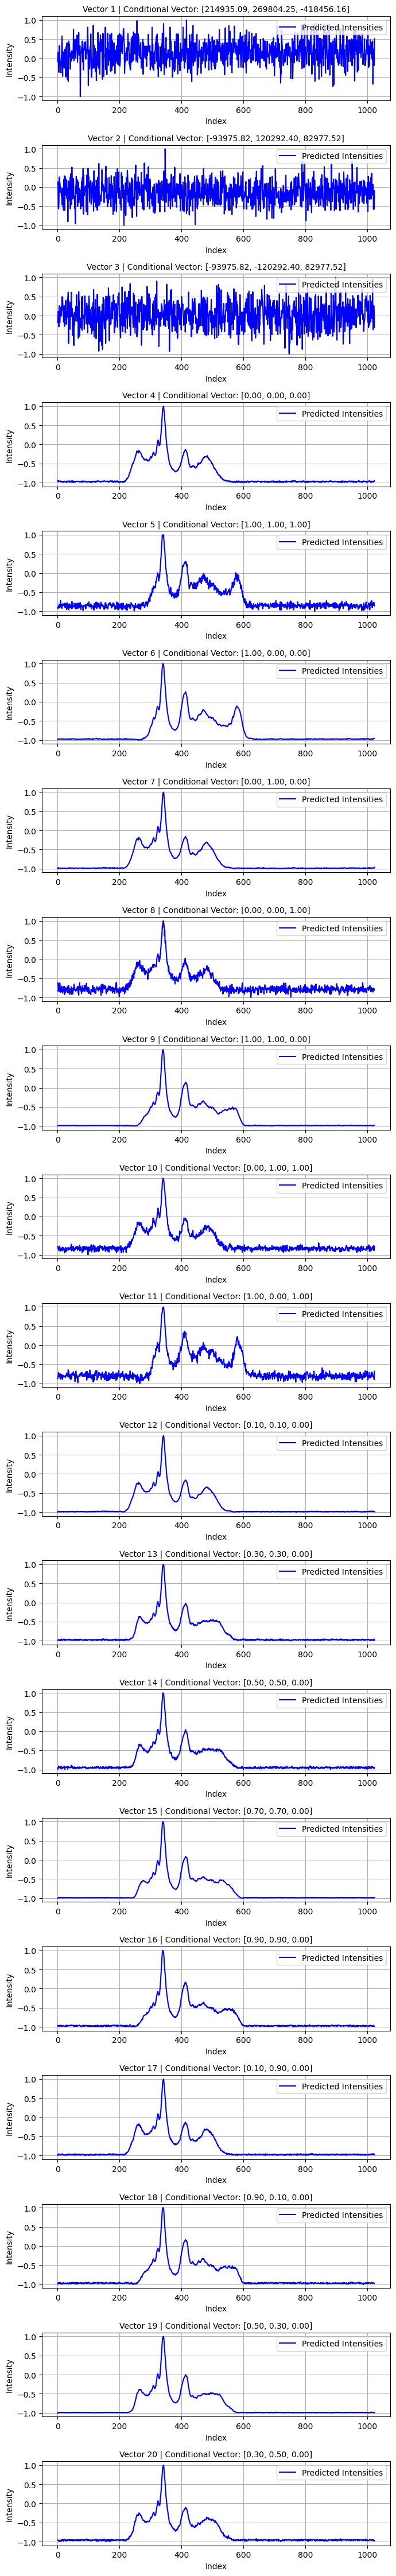

In [24]:
plot_predictions_with_cond_vectors(predictions_nonsense, cond_vectors_nonsense)

## Compare distributions

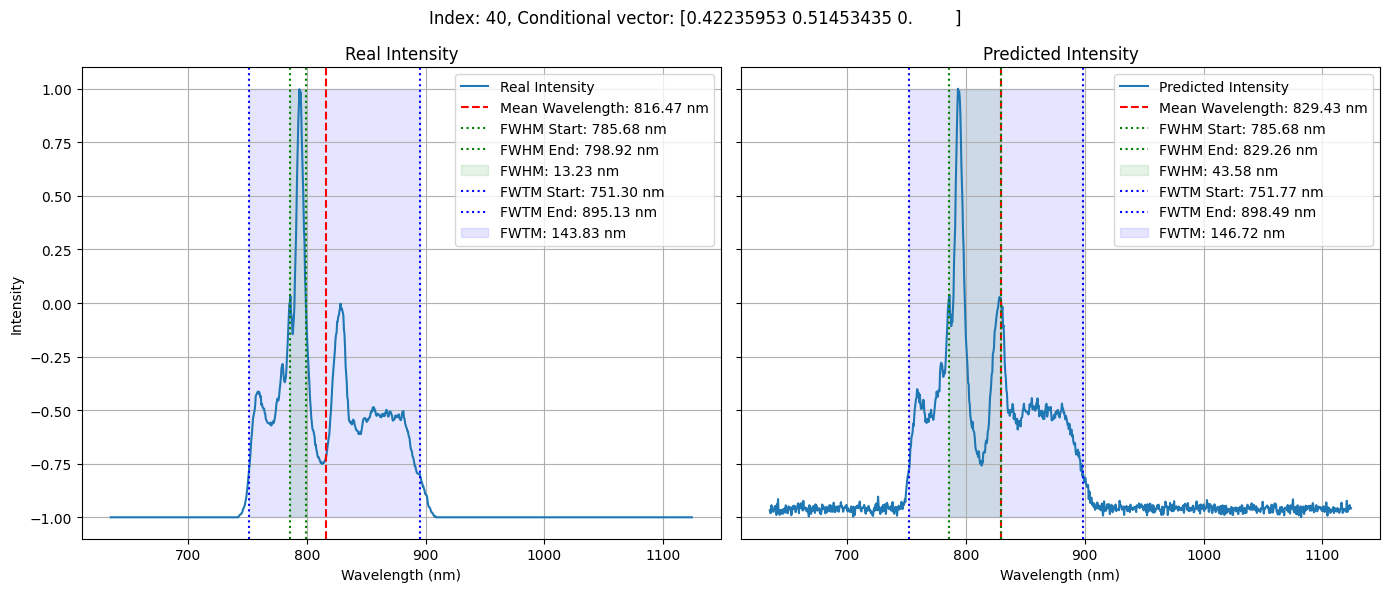

In [25]:
plot_comparison(index=40, wavelengths=wavelengths, x_real=x_real, predictions=predictions, cond_vectors=cond_vectors)

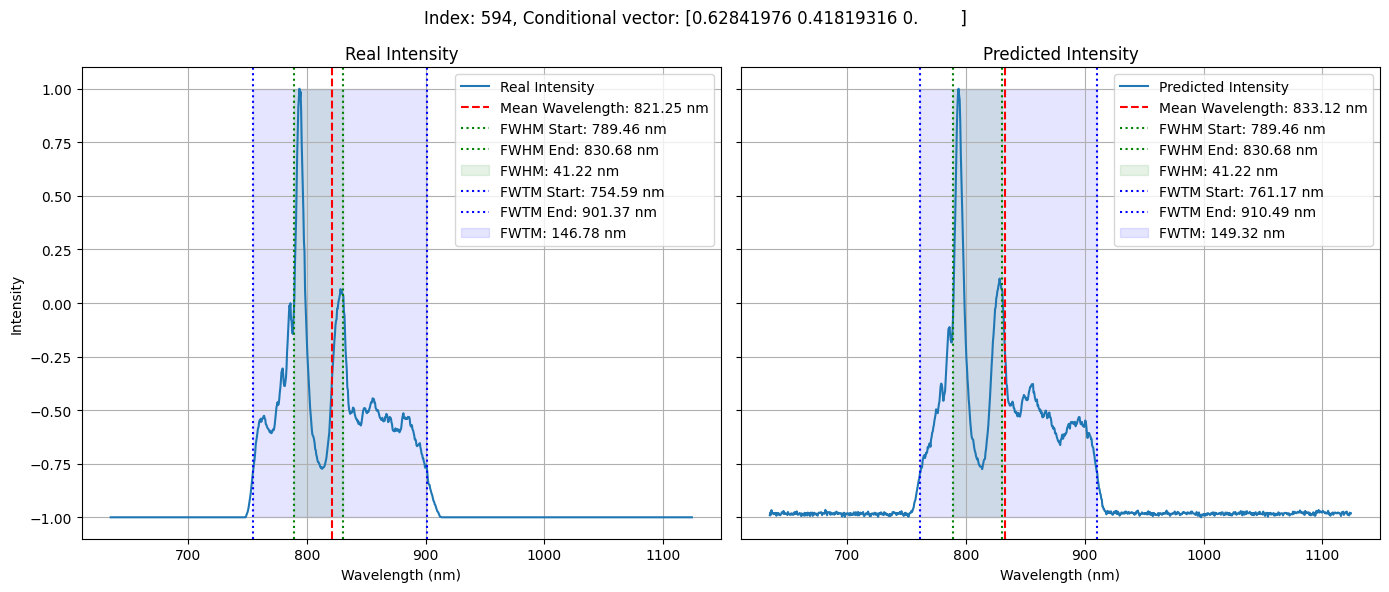

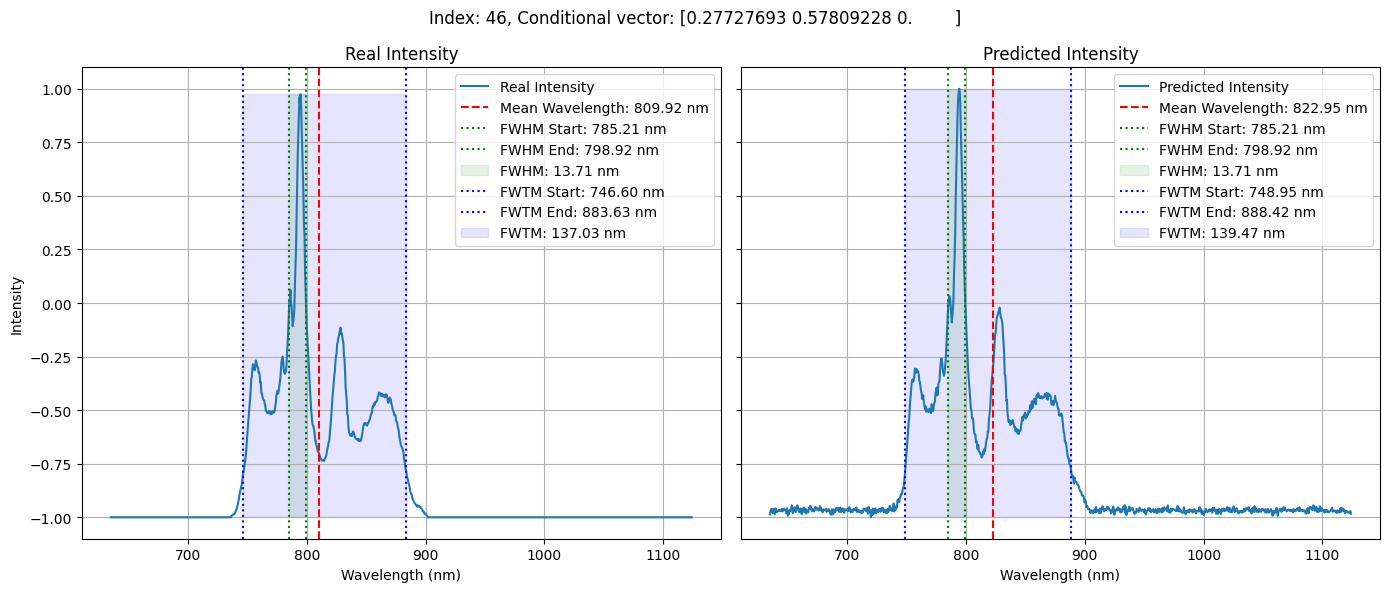

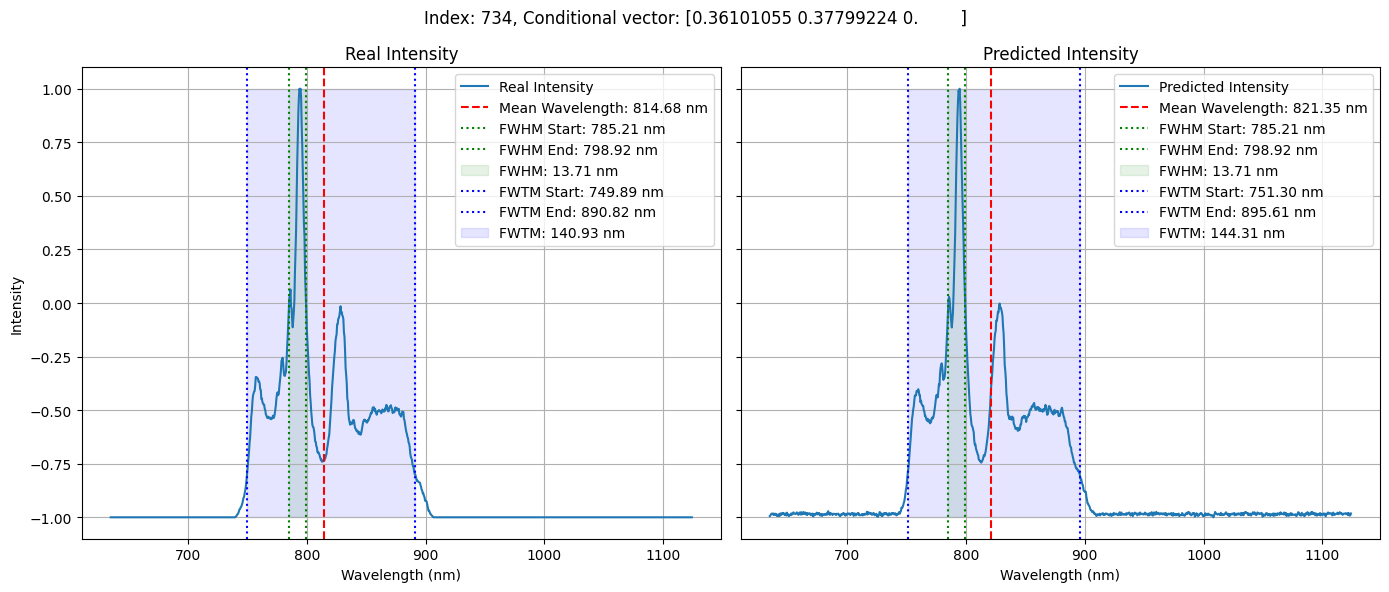

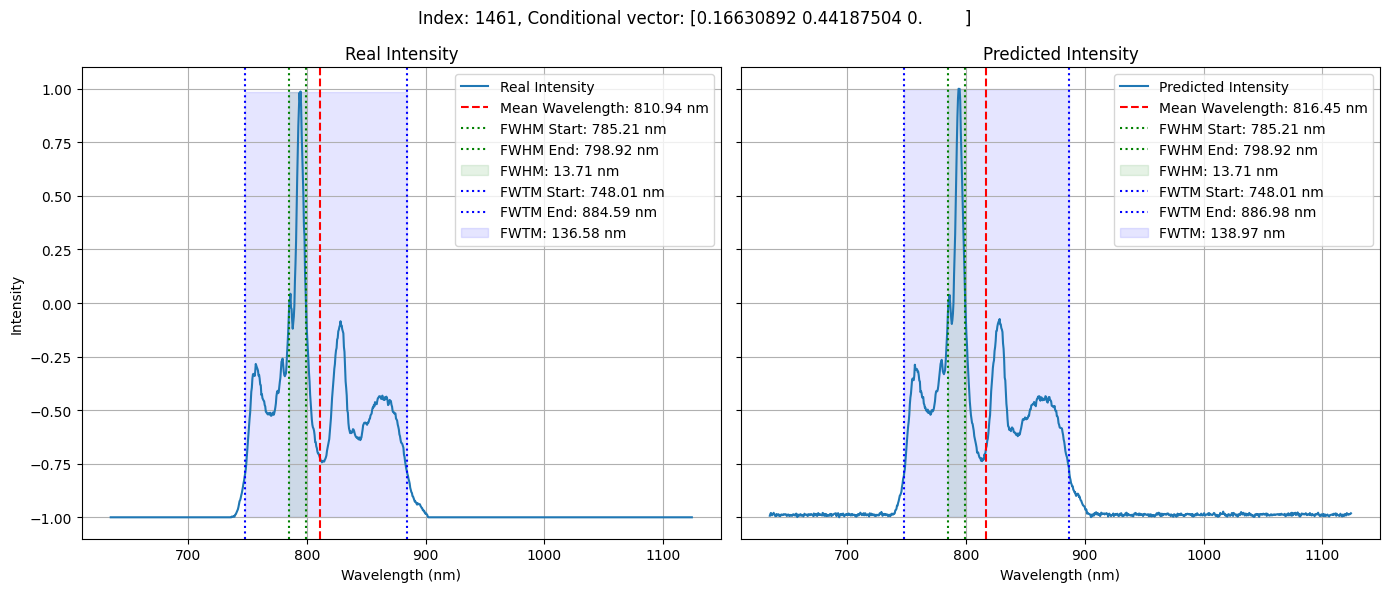

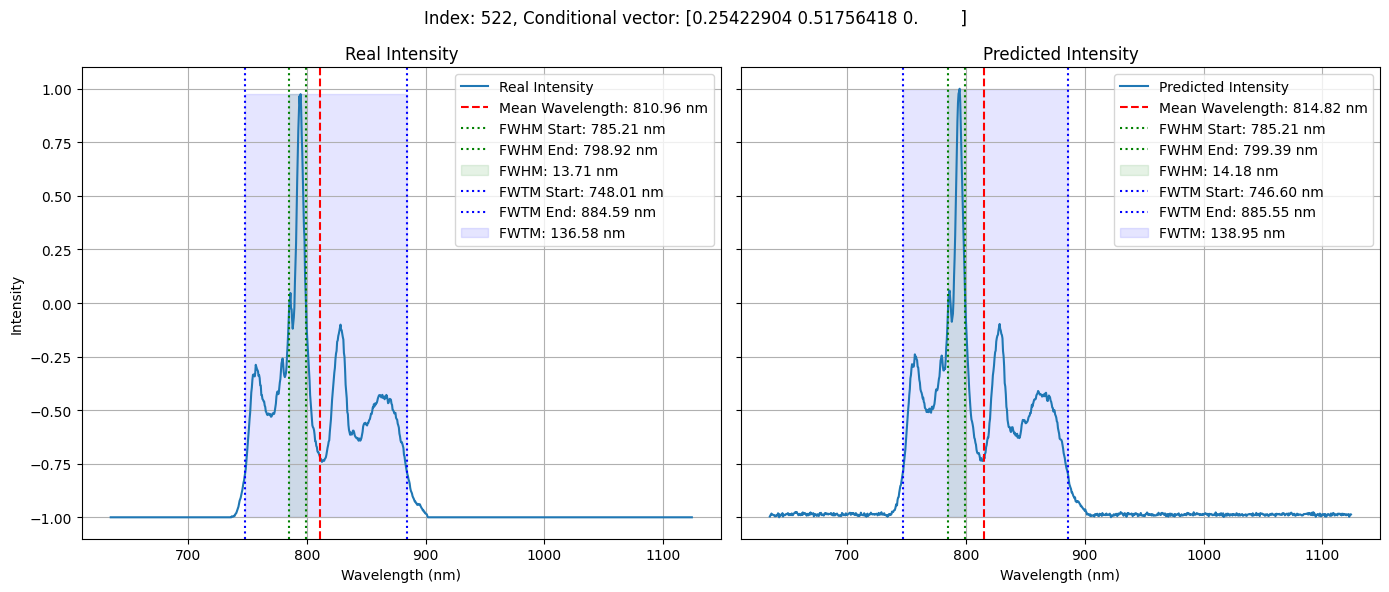

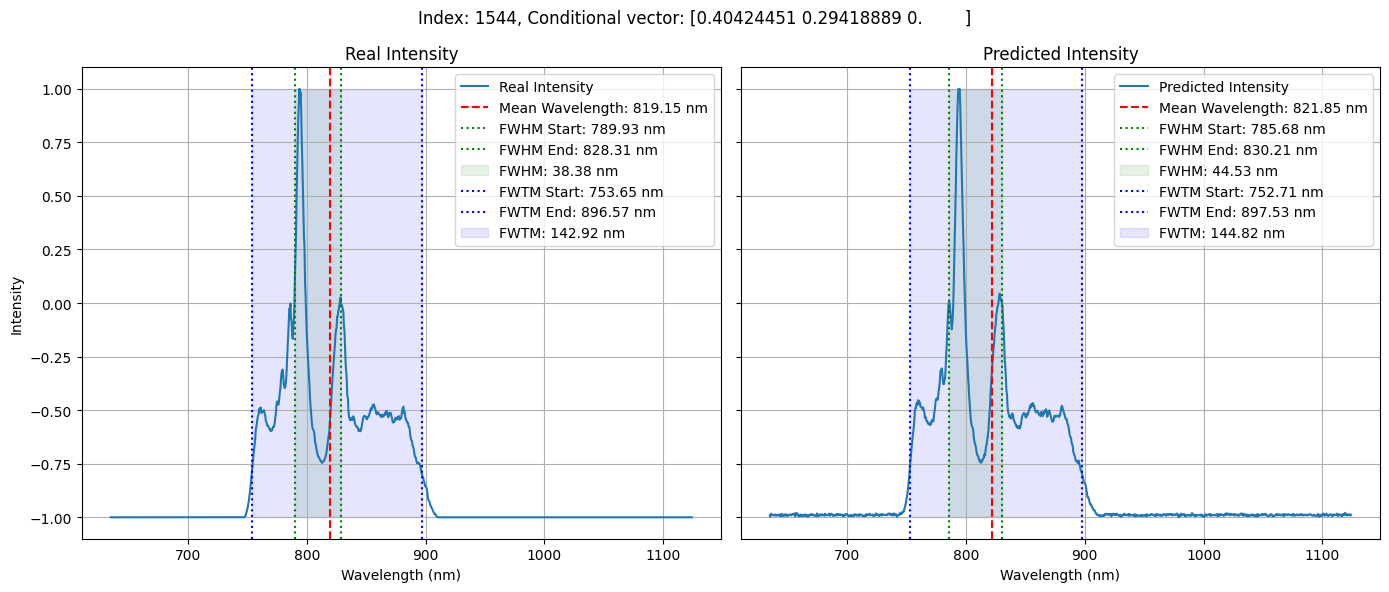

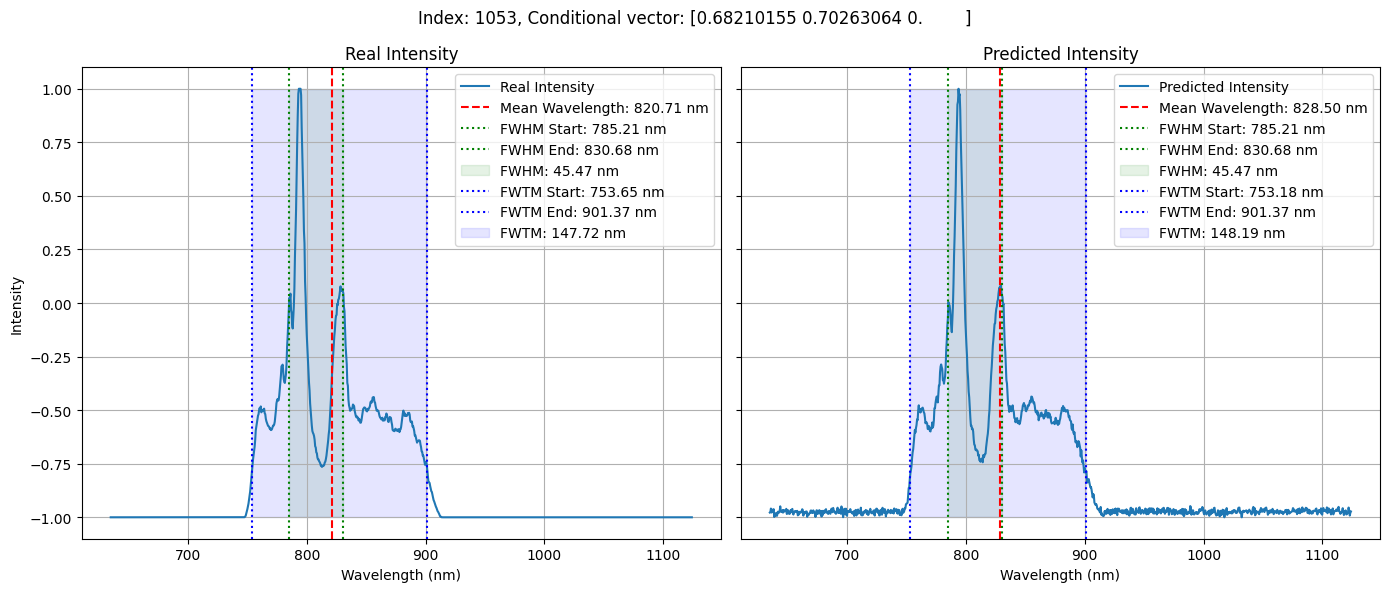

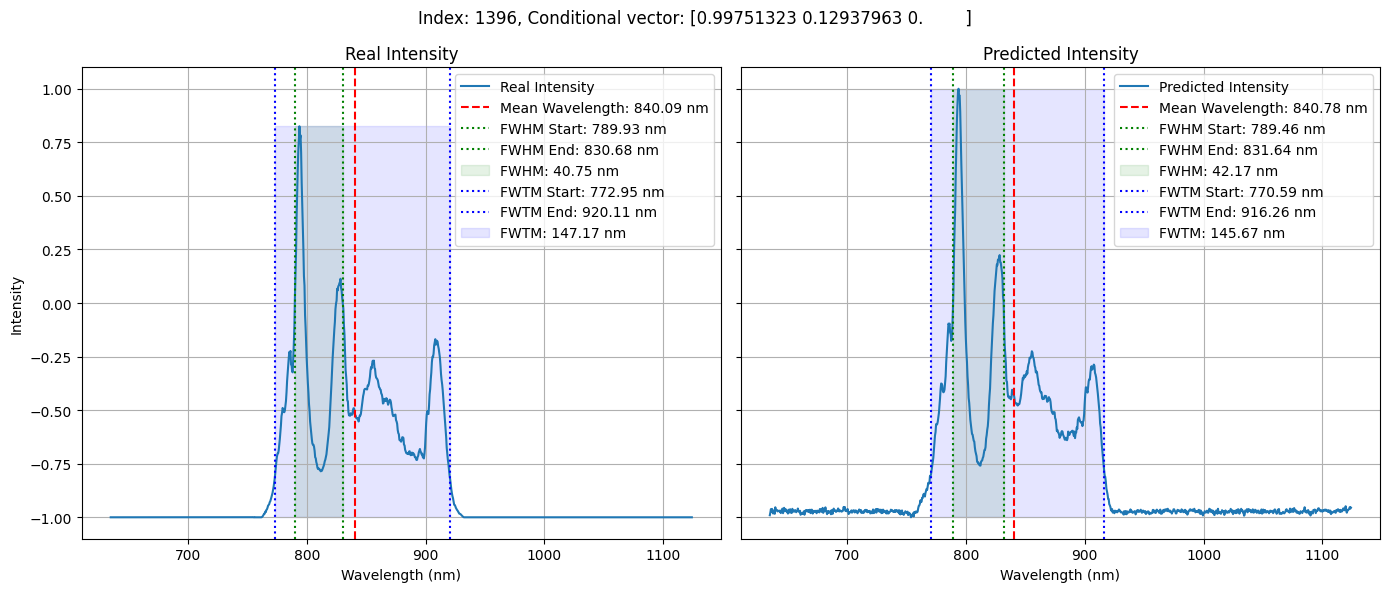

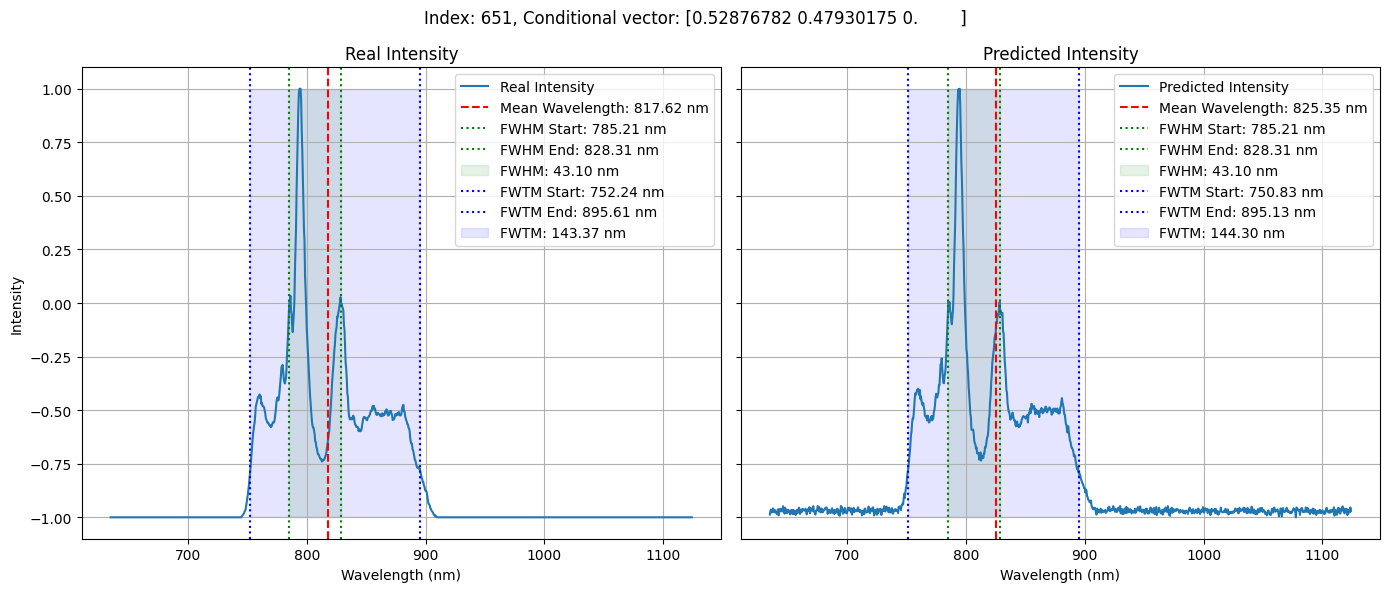

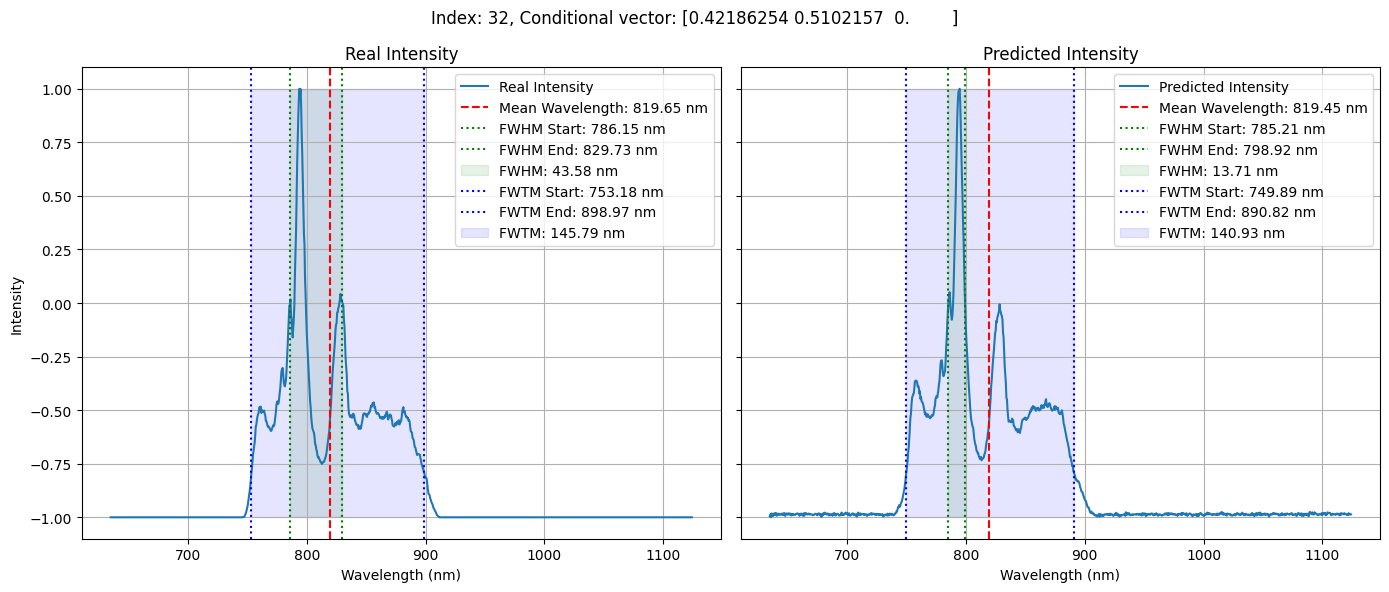

In [26]:
rand_ind = random.randint(len(x_real), size=(10))
for i in rand_ind:
    plot_comparison(index=i, wavelengths=wavelengths, x_real=x_real, predictions=predictions, cond_vectors=cond_vectors)

In [27]:
# Calculate MSE and MAE for the metrics
mse_results, mae_results = calculate_metrics_errors(wavelengths, x_real, predictions)

+-----------------+-----------+----------+
| Metric          |       MSE |      MAE |
+=================+===========+==========+
| mean_wavelength |  80.192   |  7.32246 |
+-----------------+-----------+----------+
| std_deviation   | 679.341   | 23.9465  |
+-----------------+-----------+----------+
| fwhm            | 232.75    |  8.63547 |
+-----------------+-----------+----------+
| fwhm_start      |   3.81419 |  1.10282 |
+-----------------+-----------+----------+
| fwhm_end        | 248.794   |  8.43674 |
+-----------------+-----------+----------+
| fwtm            |  78.9851  |  3.18594 |
+-----------------+-----------+----------+
| fwtm_start      |  20.3466  |  2.8956  |
+-----------------+-----------+----------+
| fwtm_end        |  66.2394  |  4.90094 |
+-----------------+-----------+----------+


In [28]:
calculate_dtw_distances(x_real, predictions)

Mean DTW Distance: 0.553921


[0.39935015395664203,
 0.5102428200009926,
 0.2887866352787015,
 0.5197802259991187,
 0.406183966678446,
 1.0084005215280585,
 0.6699142205229954,
 0.3513448321203881,
 0.2818206123459445,
 0.28245278731333595,
 0.5157054155772806,
 0.2907649041501984,
 0.5281603167915091,
 0.482040999815854,
 0.5053802840945885,
 0.8834505806806683,
 0.6165995168364036,
 0.4484085065582123,
 0.2947442627321662,
 0.31087486413319015,
 0.6234679973844457,
 0.3194526751046278,
 0.34686915440315347,
 0.4250471850992083,
 0.2042330887055283,
 0.2928434842781341,
 0.5095136024967984,
 1.1768610444189935,
 0.5360450439663738,
 0.4962784520466878,
 0.42429814878594163,
 0.3409941530893739,
 0.5401431371503731,
 0.5285973837364084,
 0.2947327447688657,
 0.9387085175605846,
 0.41399684211230425,
 0.6795556512507668,
 1.0368957472841804,
 1.3282598705267625,
 0.6056333209270247,
 0.28559444146535534,
 0.4912456134706843,
 0.7577486156540395,
 0.7199725467803506,
 0.8141749338095475,
 0.5808813769075248,
 0.78208